In [1]:
# core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# functional
import pickle
from itertools import product
from functools import partial
from torch.multiprocessing import Pool, set_start_method
import time

# custom
from scripts.classes import RnnTextClassifier, RnnDataset
from scripts.functions import tune_rnn

# warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
try:
    set_start_method('spawn')
except RuntimeError as e:
    print("The start method has already been set.")

## Load Data

In [3]:
data_names = ['bert_train', 'bert_test', 'y_train_binary', 'y_test_binary'] # 'tfidf_train', 'tfidf_test', 

for var_name in data_names:
    with open(f'data/{var_name}.pkl', 'rb') as f:
        globals()[var_name] = pickle.load(f)

## Final Tuning

In [4]:
hp_space = {
    '0_hidden_size': [120, 150, 180],
    '1_num_layers': [1, 2, 3],
    '2_dropout': [0.1, 0.2, 0.3],
    '3_batch_size': [64, 96, 128],
    '4_optimizer': [torch.optim.RMSprop],
    '5_learning_rate': [0.01, 0.05, 0.1]
}

hp_combos = list(product(*hp_space.values())) 

len(hp_combos)

243

In [5]:
tune_rnn_f1 = partial(
    tune_rnn, 
    X_train = bert_train, X_test = bert_test, 
    y_train = y_train_binary.unsqueeze(1), 
    y_test = y_test_binary.unsqueeze(1), 
    metric = f1_score
)

In [6]:
with Pool(processes = 12) as pool:
    results_f1 = pool.map(tune_rnn_f1, hp_combos)

with open(f'data/hp_result_final.pkl', 'wb') as f:
    pickle.dump(results_f1, f)

best_result_idx = results_f1.index(max(results_f1))
best_hps_f1 = hp_combos[best_result_idx]
best_hps_f1 = dict(zip(hp_space.keys(), best_hps_f1))

best_hps_f1

{'0_hidden_size': 120,
 '1_num_layers': 1,
 '2_dropout': 0.1,
 '3_batch_size': 96,
 '4_optimizer': torch.optim.rmsprop.RMSprop,
 '5_learning_rate': 0.01}

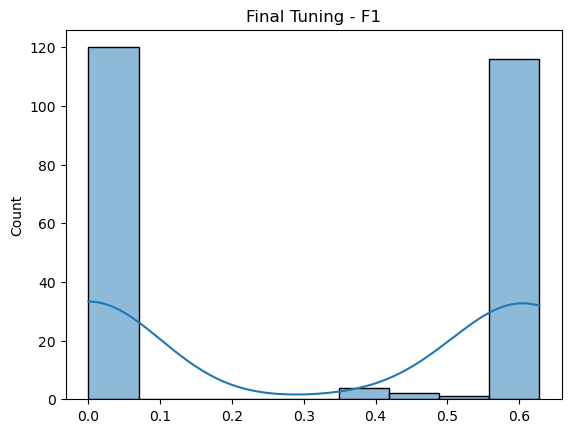

In [7]:
fig, ax = plt.subplots()
sns.histplot(results_f1, ax = ax, kde = True)
ax.set_title('Final Tuning - F1')
plt.show()

In [8]:
results_df = pd.DataFrame(hp_combos, columns = hp_space.keys())
results_df['f1'] = results_f1
results_df['4_optimizer'] = results_df['4_optimizer'].apply(lambda x: x.__name__)
results_df = results_df.sort_values(by = 'f1', ascending = False).reset_index(drop = True)
results_df.head(15)

,0_hidden_size,1_num_layers,2_dropout,3_batch_size,4_optimizer,5_learning_rate,f1
0,120,1,0.1,96,RMSprop,0.01,0.628169
1,180,1,0.1,96,RMSprop,0.01,0.624613
2,120,1,0.3,96,RMSprop,0.01,0.623153
3,150,1,0.2,64,RMSprop,0.10,0.620359
4,150,1,0.3,64,RMSprop,0.01,0.619430
5,150,1,0.3,96,RMSprop,0.01,0.618587
6,150,1,0.1,96,RMSprop,0.01,0.615764
7,120,1,0.2,96,RMSprop,0.01,0.613368
8,150,2,0.1,64,RMSprop,0.05,0.607692
9,150,1,0.3,128,RMSprop,0.10,0.607692


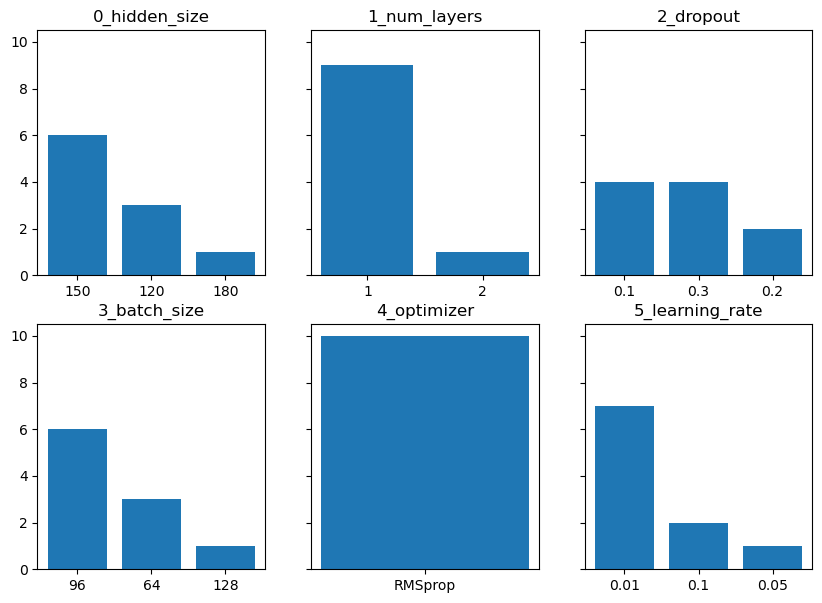

In [9]:
fig, axes = plt.subplots(2, 3, figsize = (10, 7), sharey = True)
top10 = results_df.head(10)
for hp, ax in zip(hp_space.keys(), axes.ravel()):
    ax.bar(
        [str(x) for x in top10[hp].value_counts().index.values],
        top10[hp].value_counts().values
    )
    ax.set_title(hp)
    ax.set_xlabel('')
plt.show()

## Final Hyperparameters

1. Hidden size: 150  
2. Number of layers: 1  
3. Dropout: 0.3  
4. Batch size: 96  
5. Optimizer: RMSprop  
6. Learning Rate: 0.01

# Final Model

### Rework Data

In [10]:
train = pd.read_csv('data/liars_train.csv')
test = pd.read_csv('data/liars_test.csv')
valid = pd.read_csv('data/liars_valid.csv')

train = pd.concat([train, test], axis = 0, ignore_index = True)

In [11]:
tfidf = TfidfVectorizer(stop_words = 'english', ngram_range = (1,2), max_features = 1000)
X_train = tfidf.fit_transform(train.statement)
X_valid = tfidf.transform(valid.statement)

X_train = torch.tensor(X_train.toarray(), dtype = torch.float)
X_valid = torch.tensor(X_valid.toarray(), dtype = torch.float)

print(X_train.shape, X_valid.shape)

torch.Size([11507, 1000]) torch.Size([1284, 1000])


In [12]:
y_train = train.label
y_valid = valid.label

# Convert labels to integers
false = ['false', 'pants-fire', 'barely-true']
true = ['half-true', 'mostly-true', 'true']

y_train = torch.tensor(np.where(y_train.isin(false), 1, 0), dtype = torch.float).unsqueeze(1)
y_valid = torch.tensor(np.where(y_valid.isin(false), 1, 0), dtype = torch.float).unsqueeze(1)

print(y_train.shape, y_valid.shape)

torch.Size([11507, 1]) torch.Size([1284, 1])


In [20]:
rnn = RnnTextClassifier(
    input_size = X_train.shape[1], output_size = 1, 
    hidden_size = 150, num_layers = 1, dropout = 0.3
)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(rnn.parameters(), lr = 0.01)
n_epochs = 1000
dataset = RnnDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size = 96, shuffle = True)

c:\Users\Keith\miniconda3\envs\cuny\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [21]:
start = time.perf_counter()

for epoch in range(n_epochs+1):

    for X_batch, y_batch in data_loader:

        y_pred = rnn(X_batch)
        loss = criterion(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % (n_epochs / 10) == 0:
        print(
            f'Completed Epoch: {epoch} | Loss: {loss:.4f}\n'
            f'Elapsed Time: {(time.perf_counter() - start) / 60:.2f} min'
        )

torch.save(rnn, f'models/rnn_FINAL.pth')

Completed Epoch: 0 | Loss: 0.7005
Elapsed Time: 0.00 min
Completed Epoch: 100 | Loss: 0.1010
Elapsed Time: 0.32 min
Completed Epoch: 200 | Loss: 0.0505
Elapsed Time: 0.63 min
Completed Epoch: 300 | Loss: 0.0109
Elapsed Time: 0.94 min
Completed Epoch: 400 | Loss: 0.0016
Elapsed Time: 1.26 min
Completed Epoch: 500 | Loss: 0.0044
Elapsed Time: 1.57 min
Completed Epoch: 600 | Loss: 0.0033
Elapsed Time: 1.88 min
Completed Epoch: 700 | Loss: 0.0018
Elapsed Time: 2.20 min
Completed Epoch: 800 | Loss: 0.1147
Elapsed Time: 2.51 min
Completed Epoch: 900 | Loss: 0.0205
Elapsed Time: 2.83 min
Completed Epoch: 1000 | Loss: 0.0203
Elapsed Time: 3.16 min


## Final Evaluation - Validation Set

In [22]:
rnn.eval()
y_pred = rnn(X_valid)
y_pred = torch.sigmoid(y_pred)
y_pred = y_pred > 0.5

print(
    f'----FINAL RESULTS----\n'
    f'Accuracy: {accuracy_score(y_valid, y_pred)}\n'
    f'Recall: {recall_score(y_valid, y_pred)}\n'
    f'Precision: {precision_score(y_valid, y_pred)}\n'
    f'\n{confusion_matrix(y_valid, y_pred)}'
)

----FINAL RESULTS----
Accuracy: 0.5856697819314641
Recall: 0.4902597402597403
Precision: 0.5807692307692308

[[450 218]
 [314 302]]
